# LEZIONE 10 — Gradient Boosting: Quando una Foresta Non Basta

---

## Obiettivi della Lezione

Al termine di questa lezione sarai in grado di:

1. **Comprendere l'intuizione del boosting** e come differisce dal bagging
2. **Distinguere Random Forest da Gradient Boosting** in termini di strategia
3. **Analizzare il trade-off bias-variance** nei modelli ad alberi
4. **Riconoscere l'overfitting nel boosting** e come mitigarlo
5. **Padroneggiare i parametri chiave**: `n_estimators`, `learning_rate`, `max_depth`
6. **Confrontare empiricamente** Random Forest vs Gradient Boosting

---

## Prerequisiti

- Lezione 9: Decision Tree e Random Forest
- Lezione 8: Validazione, Overfitting e Generalizzazione
- Concetti di bias e varianza

---

## Indice

1. [Section 1 — L'Intuizione del Boosting](#section-1)
2. [Section 2 — Random Forest vs Gradient Boosting](#section-2)
3. [Section 3 — Bias vs Variance nei Modelli ad Alberi](#section-3)
4. [Section 4 — Overfitting nel Boosting](#section-4)
5. [Section 5 — Parametri Chiave del Gradient Boosting](#section-5)
6. [Section 6 — Dimostrazione Guidata](#section-6)
7. [Section 7 — Esercizi Pratici](#section-7)
8. [Section 8 — Conclusioni e Prossimi Passi](#section-8)

---

## Librerie Utilizzate

```python
numpy, pandas, matplotlib, scikit-learn
```

---

## Dataset

Utilizzeremo dataset sintetici generati con `make_classification` e `make_regression` per avere controllo completo sui pattern da apprendere.

# Section 1 — L'Intuizione del Boosting

## 1.1 — Da Bagging a Boosting: Un Cambio di Paradigma

Nella Lezione 9 abbiamo visto il **Random Forest**, un metodo **ensemble** basato sul **bagging**:
- Costruisce alberi **indipendenti** su campioni bootstrap
- Combina le predizioni per **ridurre la varianza**
- Gli alberi non "parlano" tra loro

Il **Boosting** adotta una strategia radicalmente diversa:
- Costruisce alberi **sequenzialmente** (uno dopo l'altro)
- Ogni nuovo albero **corregge gli errori** del precedente
- Si concentra sui campioni "difficili" che i modelli precedenti hanno sbagliato

## 1.2 — L'Analogia dello Studente

Immagina uno studente che studia per un esame:

| Bagging (Random Forest) | Boosting (Gradient Boosting) |
|------------------------|------------------------------|
| Studia tutto il programma più volte | Studia, fa un test, poi studia SOLO gli argomenti sbagliati |
| Approccio "a tappeto" | Approccio "mirato agli errori" |
| Ogni sessione è indipendente | Ogni sessione dipende dalla precedente |

## 1.3 — Il Meccanismo Sequenziale

Il Gradient Boosting costruisce il modello finale come **somma di modelli deboli**:

$$F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot h_m(x)$$

Dove:
- $F_0(x)$ = predizione iniziale (spesso la media del target)
- $h_m(x)$ = m-esimo albero "debole" (weak learner)
- $\eta$ = **learning rate** (quanto "fidarsi" di ogni nuovo albero)
- $M$ = numero totale di alberi (`n_estimators`)

## 1.4 — Come Funziona Passo per Passo

```
Inizializzazione:
    F₀(x) = media(y)  # predizione costante iniziale

Per m = 1, 2, ..., M:
    1. Calcola i RESIDUI: rᵢ = yᵢ - Fₘ₋₁(xᵢ)
       (quanto il modello attuale sbaglia per ogni campione)
    
    2. Addestra un NUOVO ALBERO hₘ(x) sui residui
       (l'albero impara a predire GLI ERRORI)
    
    3. Aggiorna il modello: Fₘ(x) = Fₘ₋₁(x) + η · hₘ(x)
       (aggiungi la correzione, scalata dal learning rate)

Predizione finale: F_M(x)
```

## 1.5 — Perché "Gradient"?

Il termine **Gradient** deriva dal fatto che i residui che minimizziamo corrispondono al **gradiente negativo** della funzione di perdita:

- Per regressione (MSE): $-\frac{\partial L}{\partial F} = y - F(x)$ = residui classici
- Per classificazione: si usano pseudo-residui derivati dalla log-loss

In pratica, il boosting esegue una **discesa del gradiente nello spazio delle funzioni**.

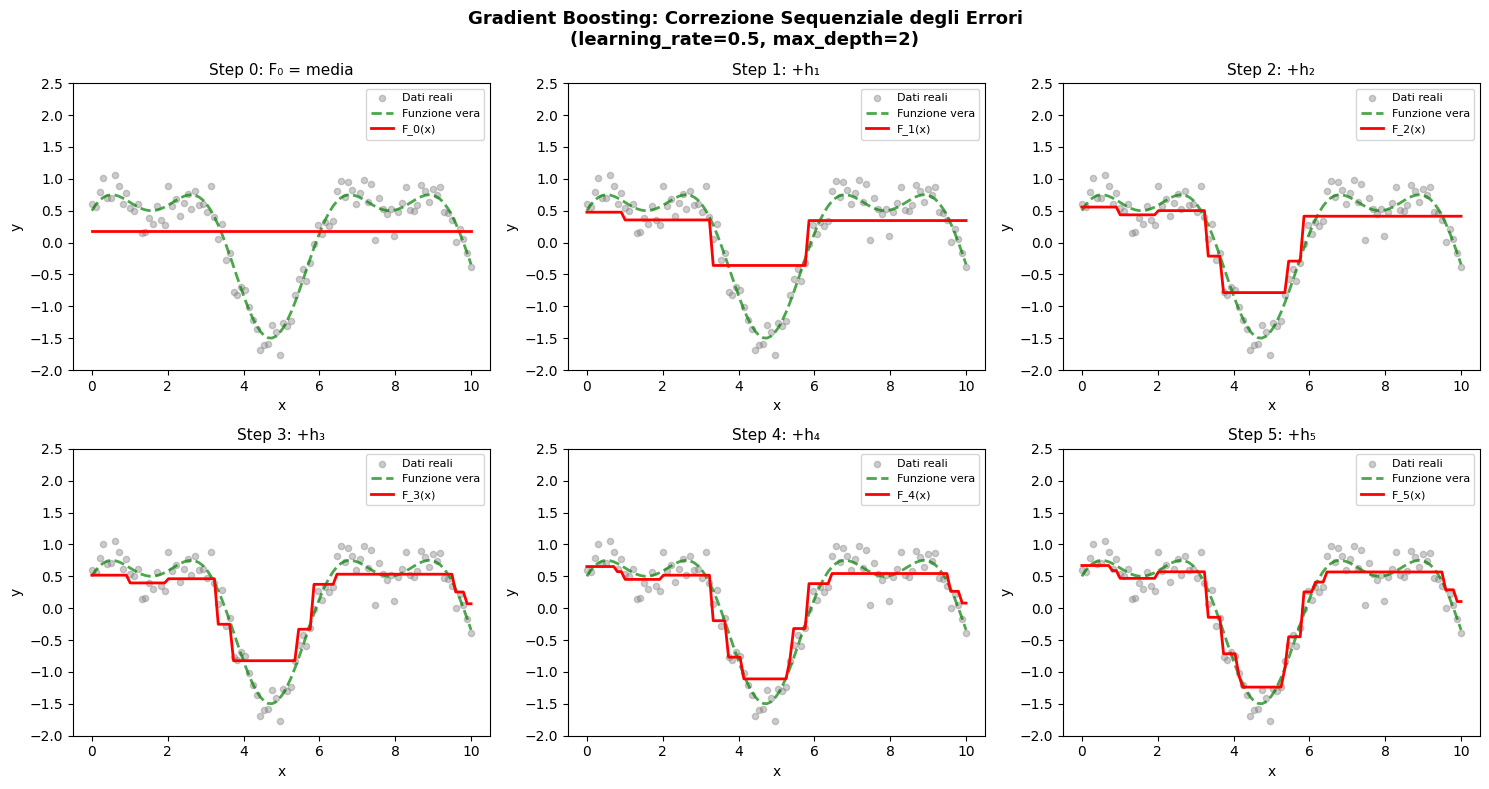

OSSERVAZIONE:
------------------------------------------------------------
• Ogni step aggiunge una correzione che riduce l'errore
• Gli alberi 'deboli' (depth=2) contribuiscono poco singolarmente
• L'ensemble finale approssima bene la funzione vera
• Il learning_rate controlla quanto 'aggressivamente' correggiamo


In [1]:
# Visualizzazione: Come il Boosting Corregge gli Errori

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

# Creiamo un dataset semplice per regressione
X_demo = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = np.sin(X_demo.ravel()) + 0.5 * np.cos(2 * X_demo.ravel())
y_demo = y_true + np.random.randn(100) * 0.2  # aggiungi rumore

# Simuliamo il boosting manualmente
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Step 0: Predizione iniziale (media)
F0 = np.full_like(y_demo, y_demo.mean())
residuals = y_demo - F0

# Parametri
learning_rate = 0.5
predictions = [F0.copy()]
trees = []

for step in range(5):
    # Addestra albero sui residui
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X_demo, residuals)
    trees.append(tree)
    
    # Predizione dell'albero
    h = tree.predict(X_demo)
    
    # Aggiorna predizione
    F_new = predictions[-1] + learning_rate * h
    predictions.append(F_new)
    
    # Nuovi residui
    residuals = y_demo - F_new

# Visualizzazione
titles = ['Step 0: F₀ = media', 'Step 1: +h₁', 'Step 2: +h₂', 
          'Step 3: +h₃', 'Step 4: +h₄', 'Step 5: +h₅']

for i, ax in enumerate(axes.flat):
    ax.scatter(X_demo, y_demo, alpha=0.4, s=20, label='Dati reali', c='gray')
    ax.plot(X_demo, y_true, 'g--', linewidth=2, label='Funzione vera', alpha=0.7)
    ax.plot(X_demo, predictions[i], 'r-', linewidth=2, label=f'F_{i}(x)')
    ax.set_title(titles[i], fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_ylim([-2, 2.5])

plt.suptitle('Gradient Boosting: Correzione Sequenziale degli Errori\n(learning_rate=0.5, max_depth=2)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("OSSERVAZIONE:")
print("-" * 60)
print("• Ogni step aggiunge una correzione che riduce l'errore")
print("• Gli alberi 'deboli' (depth=2) contribuiscono poco singolarmente")
print("• L'ensemble finale approssima bene la funzione vera")
print("• Il learning_rate controlla quanto 'aggressivamente' correggiamo")

# Section 2 — Random Forest vs Gradient Boosting

## 2.1 — Due Filosofie Diverse

| Aspetto | Random Forest | Gradient Boosting |
|---------|---------------|-------------------|
| **Strategia** | Parallela (bagging) | Sequenziale (boosting) |
| **Obiettivo** | Ridurre la **varianza** | Ridurre il **bias** |
| **Alberi** | Profondi e indipendenti | Poco profondi e correlati |
| **Errori** | Mediati via voting | Corretti iterativamente |
| **Velocità training** | Parallelizzabile | Intrinsecamente sequenziale |
| **Rischio overfitting** | Basso | Più alto (richiede tuning) |

## 2.2 — Quando Usare Quale?

### Random Forest è preferibile quando:
- Hai **poco tempo** per il tuning
- Vuoi un modello **robusto out-of-the-box**
- I dati hanno molto **rumore**
- Hai bisogno di **parallelizzazione**

### Gradient Boosting è preferibile quando:
- Vuoi **massimizzare le performance**
- Sei disposto a fare **hyperparameter tuning**
- I dati hanno pattern **complessi ma strutturati**
- Hai risorse per evitare l'overfitting

## 2.3 — Complessità Computazionale

```
Random Forest:
    Training: O(n_estimators × n × log(n) × features)
    → Parallelizzabile su n_estimators

Gradient Boosting:
    Training: O(n_estimators × n × log(n) × features)
    → NON parallelizzabile (sequenziale)
    
Predizione:
    Entrambi: O(n_estimators × depth)
```

## 2.4 — Varianti Moderne del Gradient Boosting

Il Gradient Boosting classico (sklearn) ha ispirato implementazioni ottimizzate:

| Libreria | Caratteristiche |
|----------|-----------------|
| **XGBoost** | Regularizzazione L1/L2, gestione missing values, parallelismo |
| **LightGBM** | Leaf-wise growth, molto veloce su grandi dataset |
| **CatBoost** | Gestione nativa delle feature categoriche |

In questa lezione usiamo `GradientBoostingClassifier` di scikit-learn per semplicità didattica.

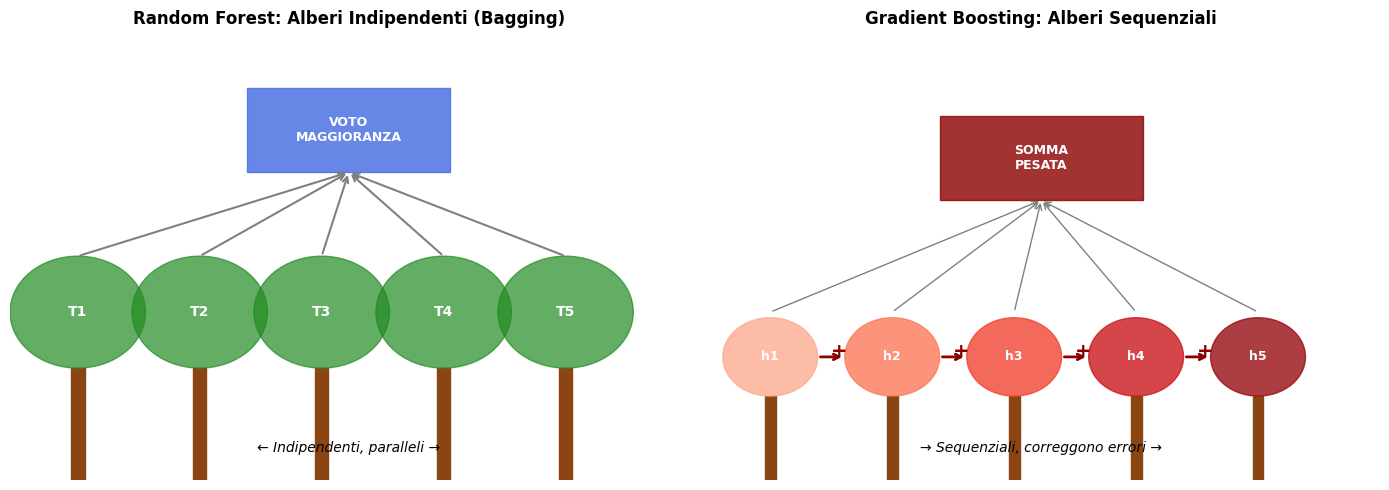

DIFFERENZE CHIAVE:
------------------------------------------------------------
• RF: alberi grandi, indipendenti → media delle predizioni
• GB: alberi piccoli, sequenziali → somma delle correzioni
• RF: parallelizzabile | GB: intrinsecamente sequenziale


In [2]:
# Confronto concettuale: come costruiscono l'ensemble

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest: alberi indipendenti
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 8)
ax1.set_title('Random Forest: Alberi Indipendenti (Bagging)', fontsize=12, fontweight='bold')

# Disegna alberi paralleli
for i in range(5):
    x_pos = 1 + i * 1.8
    # Tronco
    ax1.add_patch(plt.Rectangle((x_pos-0.1, 0), 0.2, 2, color='saddlebrown'))
    # Chioma
    ax1.add_patch(plt.Circle((x_pos, 3), 1, color='forestgreen', alpha=0.7))
    ax1.text(x_pos, 3, f'T{i+1}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    # Freccia verso il basso
    ax1.annotate('', xy=(5, 5.5), xytext=(x_pos, 4),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Box finale
ax1.add_patch(plt.Rectangle((3.5, 5.5), 3, 1.5, color='royalblue', alpha=0.8))
ax1.text(5, 6.25, 'VOTO\nMAGGIORANZA', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
ax1.text(5, 0.5, '← Indipendenti, paralleli →', ha='center', fontsize=10, style='italic')
ax1.axis('off')

# Gradient Boosting: alberi sequenziali
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 8)
ax2.set_title('Gradient Boosting: Alberi Sequenziali', fontsize=12, fontweight='bold')

# Disegna alberi in sequenza con frecce
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))
for i in range(5):
    x_pos = 1 + i * 1.8
    # Albero piccolo (weak learner)
    ax2.add_patch(plt.Rectangle((x_pos-0.08, 0), 0.16, 1.5, color='saddlebrown'))
    ax2.add_patch(plt.Circle((x_pos, 2.2), 0.7, color=colors[i], alpha=0.8))
    ax2.text(x_pos, 2.2, f'h{i+1}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    # Freccia orizzontale (sequenza)
    if i < 4:
        ax2.annotate('', xy=(x_pos + 1.1, 2.2), xytext=(x_pos + 0.7, 2.2),
                    arrowprops=dict(arrowstyle='->', color='darkred', lw=2))
    
    # Freccia verso somma
    ax2.annotate('', xy=(5, 5), xytext=(x_pos, 3),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1))

# Simboli +
for i in range(4):
    x_pos = 1.9 + i * 1.8
    ax2.text(x_pos, 2.2, '+', fontsize=14, fontweight='bold', color='darkred')

# Box finale
ax2.add_patch(plt.Rectangle((3.5, 5), 3, 1.5, color='darkred', alpha=0.8))
ax2.text(5, 5.75, 'SOMMA\nPESATA', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
ax2.text(5, 0.5, '→ Sequenziali, correggono errori →', ha='center', fontsize=10, style='italic')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("DIFFERENZE CHIAVE:")
print("-" * 60)
print("• RF: alberi grandi, indipendenti → media delle predizioni")
print("• GB: alberi piccoli, sequenziali → somma delle correzioni")
print("• RF: parallelizzabile | GB: intrinsecamente sequenziale")

# Section 3 — Bias vs Variance nei Modelli ad Alberi

## 3.1 — Ripasso: Decomposizione dell'Errore

L'errore di generalizzazione di un modello può essere decomposto in:

$$\text{Errore Totale} = \text{Bias}^2 + \text{Varianza} + \text{Rumore irriducibile}$$

| Componente | Significato | Causa |
|------------|-------------|-------|
| **Bias** | Errore sistematico, il modello "sbaglia sempre allo stesso modo" | Modello troppo semplice |
| **Varianza** | Sensibilità ai dati di training, predizioni instabili | Modello troppo complesso |
| **Rumore** | Errore inevitabile nei dati | Intrinseco al problema |

## 3.2 — Bias e Varianza nei Decision Tree

Un **singolo Decision Tree** ha:
- **Bias basso**: può approssimare funzioni molto complesse
- **Varianza alta**: piccoli cambiamenti nei dati → alberi molto diversi

## 3.3 — Come gli Ensemble Riducono l'Errore

### Random Forest → Riduce la VARIANZA

```
Varianza(media di B alberi) ≈ Varianza(singolo albero) / B
```

- Usa alberi profondi (basso bias, alta varianza)
- La media di B alberi instabili → predizione stabile
- Il bias rimane circa lo stesso

### Gradient Boosting → Riduce il BIAS

```
Bias diminuisce ad ogni iterazione (correzione degli errori)
```

- Usa alberi poco profondi (alto bias, bassa varianza)
- Ogni albero corregge gli errori → bias diminuisce progressivamente
- ⚠️ Ma attenzione: troppi alberi → la varianza aumenta (overfitting)

## 3.4 — Schema Riassuntivo

```
                    BIAS ALTO              BIAS BASSO
                    (underfitting)         (buon fit)
                ┌──────────────────────────────────────┐
VARIANZA ALTA   │  Albero poco profondo  │  Albero molto profondo │
(overfitting)   │  pochi dati            │  (singolo DT)          │
                ├──────────────────────────────────────┤
VARIANZA BASSA  │  Modello troppo        │  🎯 OBIETTIVO:         │
(stabile)       │  semplice (baseline)   │  Random Forest o       │
                │                        │  GB ben tunato         │
                └──────────────────────────────────────┘
```

Analisi Bias-Variance: RF vs GB al variare di n_estimators


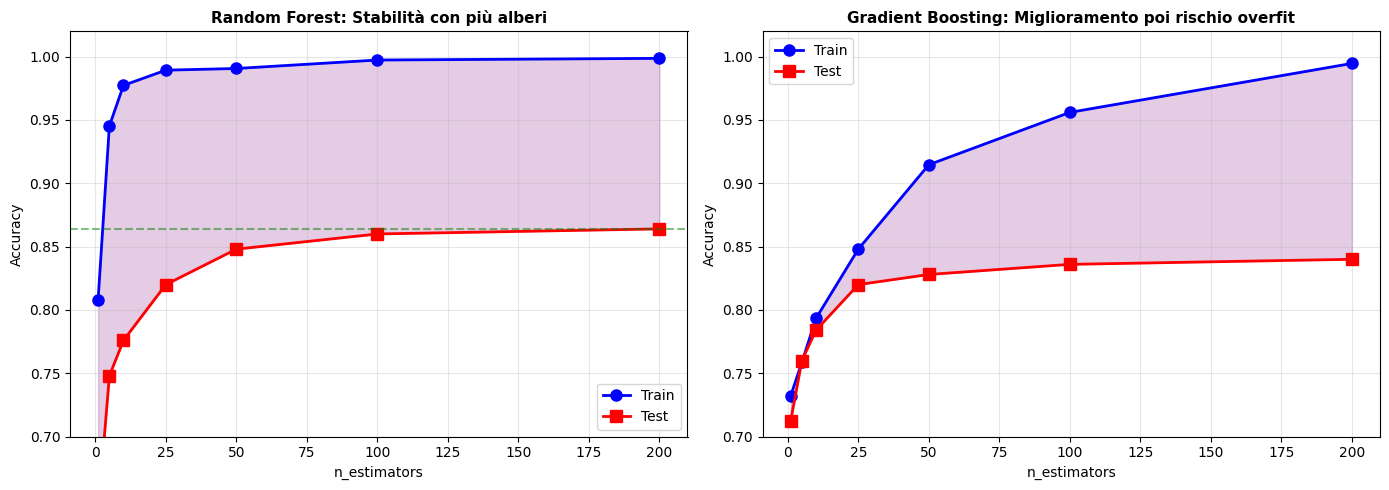


📊 INTERPRETAZIONE:
------------------------------------------------------------
• RF: il gap train-test rimane STABILE con più alberi
  → La varianza si riduce, il bias resta costante
• GB: il gap train-test può AUMENTARE con troppi alberi
  → Il bias si riduce, ma la varianza può crescere (overfit)


In [3]:
# Visualizzazione: Bias-Variance Trade-off in RF vs GB

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Dataset con rumore moderato
X, y = make_classification(
    n_samples=1000, n_features=15, n_informative=8, 
    n_redundant=2, flip_y=0.1, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Test: come varia la performance con la complessità
n_estimators_range = [1, 5, 10, 25, 50, 100, 200]

rf_train_scores = []
rf_test_scores = []
gb_train_scores = []
gb_test_scores = []

print("Analisi Bias-Variance: RF vs GB al variare di n_estimators")
print("=" * 70)

for n_est in n_estimators_range:
    # Random Forest
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    rf_train_scores.append(rf.score(X_train, y_train))
    rf_test_scores.append(rf.score(X_test, y_test))
    
    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=3, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    gb_train_scores.append(gb.score(X_train, y_train))
    gb_test_scores.append(gb.score(X_test, y_test))

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
ax1 = axes[0]
ax1.plot(n_estimators_range, rf_train_scores, 'b-o', label='Train', linewidth=2, markersize=8)
ax1.plot(n_estimators_range, rf_test_scores, 'r-s', label='Test', linewidth=2, markersize=8)
ax1.fill_between(n_estimators_range, rf_train_scores, rf_test_scores, alpha=0.2, color='purple')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Accuracy')
ax1.set_title('Random Forest: Stabilità con più alberi', fontsize=11, fontweight='bold')
ax1.legend()
ax1.set_ylim([0.7, 1.02])
ax1.grid(True, alpha=0.3)
ax1.axhline(y=rf_test_scores[-1], color='green', linestyle='--', alpha=0.5)

# Gradient Boosting
ax2 = axes[1]
ax2.plot(n_estimators_range, gb_train_scores, 'b-o', label='Train', linewidth=2, markersize=8)
ax2.plot(n_estimators_range, gb_test_scores, 'r-s', label='Test', linewidth=2, markersize=8)
ax2.fill_between(n_estimators_range, gb_train_scores, gb_test_scores, alpha=0.2, color='purple')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('Accuracy')
ax2.set_title('Gradient Boosting: Miglioramento poi rischio overfit', fontsize=11, fontweight='bold')
ax2.legend()
ax2.set_ylim([0.7, 1.02])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETAZIONE:")
print("-" * 60)
print("• RF: il gap train-test rimane STABILE con più alberi")
print("  → La varianza si riduce, il bias resta costante")
print("• GB: il gap train-test può AUMENTARE con troppi alberi")
print("  → Il bias si riduce, ma la varianza può crescere (overfit)")

# Section 4 — Overfitting nel Boosting

## 4.1 — Perché il Boosting è Più Soggetto a Overfitting

Il Gradient Boosting ha un rischio di overfitting più elevato rispetto al Random Forest per diversi motivi:

1. **Correzione iterativa degli errori**: ogni nuovo albero si focalizza sugli errori, incluso il **rumore**
2. **Alberi correlati**: a differenza di RF, gli alberi non sono indipendenti
3. **Nessuna media**: si sommano le predizioni, non si fa averaging

## 4.2 — Segnali di Overfitting nel Boosting

| Segnale | Cosa indica |
|---------|-------------|
| Train accuracy → 100% | Il modello memorizza i dati |
| Gap train-test che cresce | Generalizzazione che peggiora |
| Test accuracy che decresce dopo un picco | Troppi alberi |
| Learning curve che non migliora | Modello saturato |

## 4.3 — Strategie Anti-Overfitting

### 1. Ridurre `n_estimators`
Meno alberi = meno correzioni = meno rischio di fittare il rumore

### 2. Abbassare il `learning_rate`
$$\eta \downarrow \Rightarrow \text{correzioni più piccole} \Rightarrow \text{convergenza più lenta ma stabile}$$

**Regola pratica**: se dimezzi learning_rate, raddoppia n_estimators

### 3. Limitare `max_depth`
Alberi più "deboli" (depth 2-5) prevengono l'overfitting

### 4. Usare `subsample` < 1.0
Campionamento casuale (stochastic gradient boosting) aggiunge regolarizzazione

### 5. Early Stopping
Fermare il training quando la validation score smette di migliorare

## 4.4 — La Regola d'Oro

```
n_estimators ↑ + learning_rate ↓ = Più stabile, ma più lento

La combinazione ottimale si trova con CROSS-VALIDATION
```

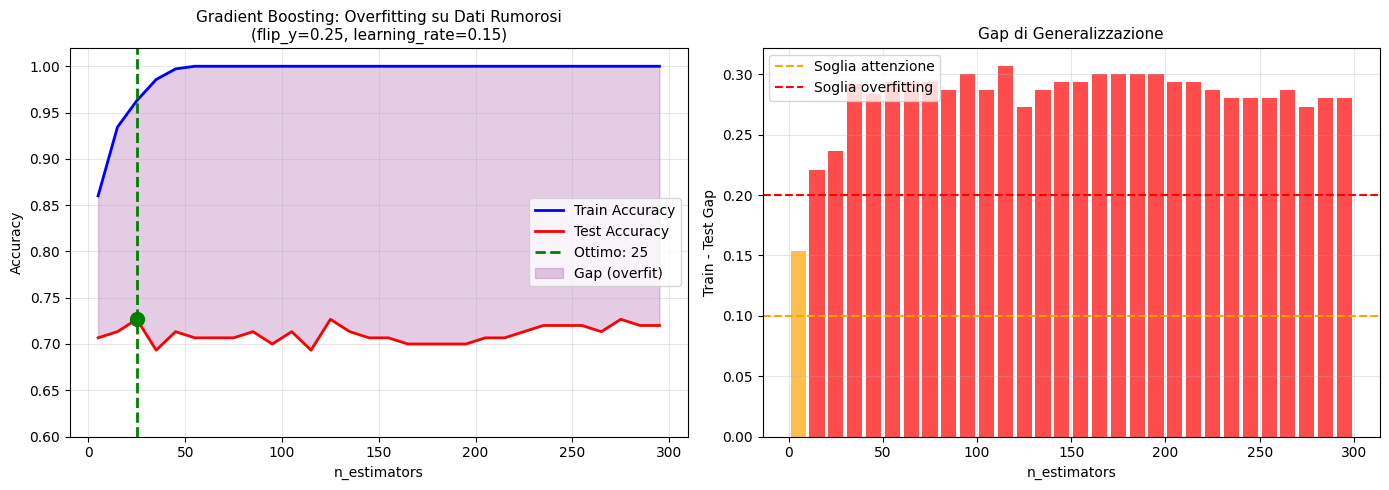


📊 RISULTATI:
------------------------------------------------------------
• Numero ottimale di alberi: 25
• Test accuracy massima: 0.7267
• Oltre 25 alberi: il modello inizia a memorizzare il rumore
• Con 300 alberi: train=1.000, test=0.720, gap=0.280


In [4]:
# Dimostrazione: Overfitting nel Gradient Boosting

# Creiamo un dataset MOLTO rumoroso per evidenziare l'overfitting
X_noisy, y_noisy = make_classification(
    n_samples=500, n_features=10, n_informative=4, 
    n_redundant=2, flip_y=0.25,  # 25% rumore!
    random_state=42
)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X_noisy, y_noisy, test_size=0.3, random_state=42
)

# Test con diversi n_estimators
estimators_range = range(5, 305, 10)
train_scores = []
test_scores = []

for n_est in estimators_range:
    gb = GradientBoostingClassifier(
        n_estimators=n_est, 
        max_depth=4,  # alberi abbastanza profondi
        learning_rate=0.15,  # learning rate medio-alto
        random_state=42
    )
    gb.fit(X_train_n, y_train_n)
    train_scores.append(gb.score(X_train_n, y_train_n))
    test_scores.append(gb.score(X_test_n, y_test_n))

# Trova il punto ottimale
best_idx = np.argmax(test_scores)
best_n_est = list(estimators_range)[best_idx]
best_test_score = test_scores[best_idx]

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Curve di apprendimento
ax1 = axes[0]
ax1.plot(estimators_range, train_scores, 'b-', label='Train Accuracy', linewidth=2)
ax1.plot(estimators_range, test_scores, 'r-', label='Test Accuracy', linewidth=2)
ax1.axvline(x=best_n_est, color='green', linestyle='--', linewidth=2, label=f'Ottimo: {best_n_est}')
ax1.fill_between(estimators_range, train_scores, test_scores, alpha=0.2, color='purple', label='Gap (overfit)')
ax1.scatter([best_n_est], [best_test_score], s=100, c='green', zorder=5)
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Accuracy')
ax1.set_title('Gradient Boosting: Overfitting su Dati Rumorosi\n(flip_y=0.25, learning_rate=0.15)', fontsize=11)
ax1.legend(loc='right')
ax1.set_ylim([0.6, 1.02])
ax1.grid(True, alpha=0.3)

# Plot 2: Gap come indicatore
gaps = [tr - te for tr, te in zip(train_scores, test_scores)]
colors = ['green' if g < 0.1 else 'orange' if g < 0.2 else 'red' for g in gaps]
ax2 = axes[1]
ax2.bar(estimators_range, gaps, color=colors, width=8, alpha=0.7)
ax2.axhline(y=0.1, color='orange', linestyle='--', label='Soglia attenzione')
ax2.axhline(y=0.2, color='red', linestyle='--', label='Soglia overfitting')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('Train - Test Gap')
ax2.set_title('Gap di Generalizzazione', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 RISULTATI:")
print("-" * 60)
print(f"• Numero ottimale di alberi: {best_n_est}")
print(f"• Test accuracy massima: {best_test_score:.4f}")
print(f"• Oltre {best_n_est} alberi: il modello inizia a memorizzare il rumore")
print(f"• Con 300 alberi: train={train_scores[-1]:.3f}, test={test_scores[-1]:.3f}, gap={gaps[-1]:.3f}")

# Section 5 — Parametri Chiave del Gradient Boosting

## 5.1 — I Tre Parametri Fondamentali

### `n_estimators` — Numero di Alberi

| Valore | Effetto |
|--------|---------|
| Troppo basso (< 50) | Underfitting, bias alto |
| Ottimale (50-300) | Buon trade-off |
| Troppo alto (> 500) | Rischio overfitting, tempo lungo |

**Consiglio**: Inizia con 100, poi tuna con cross-validation

### `learning_rate` (η) — Tasso di Apprendimento

Controlla quanto ogni albero contribuisce alla predizione finale:

$$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$$

| Valore | Effetto |
|--------|---------|
| Alto (0.1 - 1.0) | Convergenza veloce, rischio overfit |
| Basso (0.01 - 0.1) | Convergenza lenta, più stabile |
| Molto basso (< 0.01) | Richiede molti alberi |

**Regola pratica**: `learning_rate × n_estimators ≈ costante`

### `max_depth` — Profondità degli Alberi

| Valore | Effetto |
|--------|---------|
| 1 (decision stump) | Alberi molto deboli, solo interazioni semplici |
| 2-4 | Raccomandato per boosting |
| 5-8 | Per problemi complessi, rischio overfit |
| > 10 | Raramente necessario |

**Consiglio**: Per GB, preferire alberi poco profondi (depth 3-5)

## 5.2 — Altri Parametri Utili

| Parametro | Descrizione | Valori tipici |
|-----------|-------------|---------------|
| `subsample` | Frazione di campioni per albero | 0.5 - 1.0 |
| `min_samples_split` | Campioni minimi per split | 2 - 20 |
| `min_samples_leaf` | Campioni minimi nelle foglie | 1 - 10 |
| `max_features` | Features considerate per split | 'sqrt', 'log2', 0.5 |

## 5.3 — Interazione tra Parametri

```
STABILITÀ MASSIMA:
    learning_rate = 0.01
    n_estimators = 1000
    max_depth = 3
    subsample = 0.8

VELOCITÀ MASSIMA:
    learning_rate = 0.3
    n_estimators = 50
    max_depth = 5
    subsample = 1.0

BILANCIATO:
    learning_rate = 0.1
    n_estimators = 100-200
    max_depth = 3-4
    subsample = 0.8
```

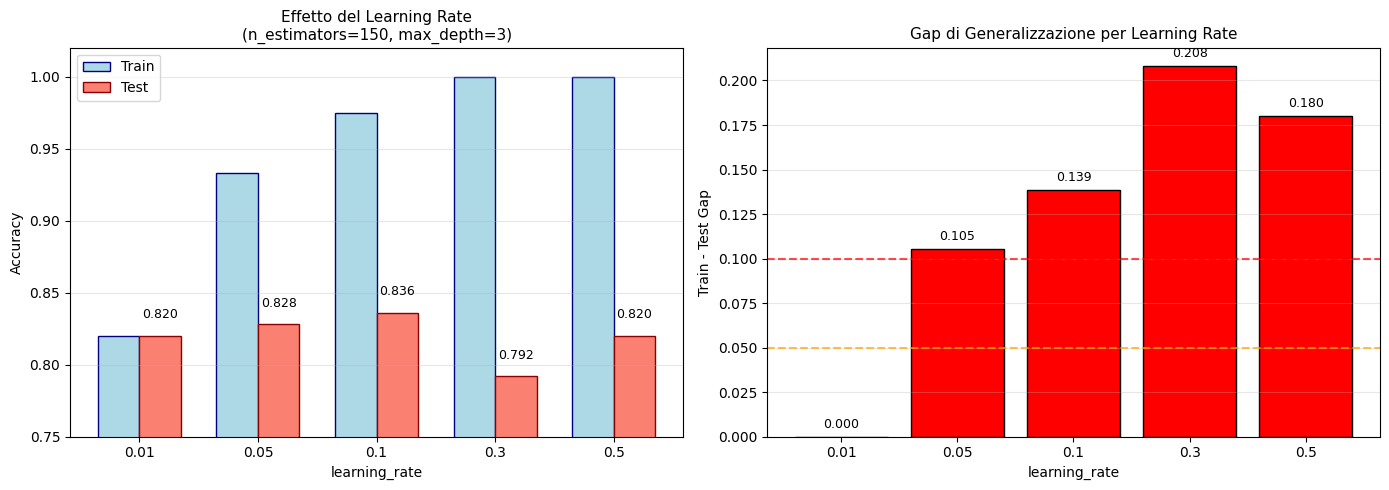


📊 INTERPRETAZIONE:
------------------------------------------------------------
• Learning rate BASSO (0.01): convergenza lenta, potrebbe servire più alberi
• Learning rate MEDIO (0.1): buon bilanciamento
• Learning rate ALTO (0.3-0.5): convergenza veloce ma gap maggiore

💡 REGOLA: lr × n_estimators ≈ 10-30 è spesso un buon punto di partenza


In [5]:
# Dimostrazione: Effetto del Learning Rate

# Usiamo il dataset originale (meno rumoroso)
learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5]
n_est_fixed = 150

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_lr = {}
for lr in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators=n_est_fixed,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    gb.fit(X_train, y_train)
    train_acc = gb.score(X_train, y_train)
    test_acc = gb.score(X_test, y_test)
    results_lr[lr] = {'train': train_acc, 'test': test_acc, 'gap': train_acc - test_acc}

# Plot 1: Train vs Test per learning rate
lrs = list(results_lr.keys())
trains = [results_lr[lr]['train'] for lr in lrs]
tests = [results_lr[lr]['test'] for lr in lrs]
gaps = [results_lr[lr]['gap'] for lr in lrs]

x = np.arange(len(lrs))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, trains, width, label='Train', color='lightblue', edgecolor='navy')
bars2 = ax1.bar(x + width/2, tests, width, label='Test', color='salmon', edgecolor='darkred')
ax1.set_xlabel('learning_rate')
ax1.set_ylabel('Accuracy')
ax1.set_title(f'Effetto del Learning Rate\n(n_estimators={n_est_fixed}, max_depth=3)', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels([str(lr) for lr in lrs])
ax1.legend()
ax1.set_ylim([0.75, 1.02])
ax1.grid(True, alpha=0.3, axis='y')

# Aggiungi valori sopra le barre
for bar, val in zip(bars2, tests):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Gap
colors_gap = ['green' if g < 0.05 else 'orange' if g < 0.1 else 'red' for g in gaps]
ax2 = axes[1]
ax2.bar(x, gaps, color=colors_gap, edgecolor='black')
ax2.set_xlabel('learning_rate')
ax2.set_ylabel('Train - Test Gap')
ax2.set_title('Gap di Generalizzazione per Learning Rate', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels([str(lr) for lr in lrs])
ax2.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7)
ax2.axhline(y=0.1, color='red', linestyle='--', alpha=0.7)
ax2.grid(True, alpha=0.3, axis='y')

for i, g in enumerate(gaps):
    ax2.text(i, g + 0.005, f'{g:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETAZIONE:")
print("-" * 60)
print("• Learning rate BASSO (0.01): convergenza lenta, potrebbe servire più alberi")
print("• Learning rate MEDIO (0.1): buon bilanciamento")
print("• Learning rate ALTO (0.3-0.5): convergenza veloce ma gap maggiore")
print("\n💡 REGOLA: lr × n_estimators ≈ 10-30 è spesso un buon punto di partenza")

# Section 6 — Dimostrazione Guidata: RF vs GB

In questa sezione confrontiamo empiricamente Random Forest e Gradient Boosting su un dataset sintetico, analizzando le metriche in modo approfondito.

## 6.1 — Setup dell'Esperimento

- **Dataset**: 1200 campioni, 20 features, 10% rumore
- **Modelli**: Random Forest e Gradient Boosting con parametri comparabili
- **Validazione**: Train/Test split + Cross-validation 5-fold
- **Metriche**: Accuracy, Precision, Recall, F1-Score

In [6]:
# Setup: Dataset e Modelli per il confronto

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
import pandas as pd

# Creiamo un dataset più grande e realistico
X_full, y_full = make_classification(
    n_samples=1200,
    n_features=20,
    n_informative=12,
    n_redundant=4,
    n_clusters_per_class=2,
    flip_y=0.1,  # 10% rumore
    random_state=42
)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_full, y_full, test_size=0.25, stratify=y_full, random_state=42
)

print("="*70)
print("DATASET PER IL CONFRONTO")
print("="*70)
print(f"Training set:  {X_train_f.shape[0]} campioni")
print(f"Test set:      {X_test_f.shape[0]} campioni")
print(f"Features:      {X_train_f.shape[1]}")
print(f"Classi:        {np.unique(y_full)}")
print(f"Distribuzione: Classe 0 = {(y_full==0).sum()}, Classe 1 = {(y_full==1).sum()}")
print(f"Rumore:        ~10% delle etichette sono errate")
print("="*70)

# Definiamo i modelli
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        random_state=42
    )
}

print("\nMODELLI CONFIGURATI:")
print("-"*70)
for name, model in models.items():
    print(f"\n{name}:")
    params = model.get_params()
    key_params = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'min_samples_split']
    for p in key_params:
        if p in params and params[p] is not None:
            print(f"   {p}: {params[p]}")

DATASET PER IL CONFRONTO
Training set:  900 campioni
Test set:      300 campioni
Features:      20
Classi:        [0 1]
Distribuzione: Classe 0 = 599, Classe 1 = 601
Rumore:        ~10% delle etichette sono errate

MODELLI CONFIGURATI:
----------------------------------------------------------------------

Random Forest:
   n_estimators: 150
   max_depth: 10
   min_samples_split: 5

Gradient Boosting:
   n_estimators: 150
   max_depth: 4
   learning_rate: 0.1
   subsample: 0.8
   min_samples_split: 2


In [7]:
# Confronto completo: Training, Predizione, Metriche

results_comparison = {}

print("="*70)
print("CONFRONTO RANDOM FOREST vs GRADIENT BOOSTING")
print("="*70)

for name, model in models.items():
    print(f"\n📊 {name}")
    print("-"*50)
    
    # Training
    model.fit(X_train_f, y_train_f)
    
    # Predizioni
    y_train_pred = model.predict(X_train_f)
    y_test_pred = model.predict(X_test_f)
    
    # Metriche
    train_acc = accuracy_score(y_train_f, y_train_pred)
    test_acc = accuracy_score(y_test_f, y_test_pred)
    precision = precision_score(y_test_f, y_test_pred)
    recall = recall_score(y_test_f, y_test_pred)
    f1 = f1_score(y_test_f, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_full, y_full, cv=5, scoring='accuracy')
    
    results_comparison[name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'gap': train_acc - test_acc
    }
    
    print(f"   Train Accuracy:    {train_acc:.4f}")
    print(f"   Test Accuracy:     {test_acc:.4f}")
    print(f"   Gap (overfit):     {train_acc - test_acc:.4f}")
    print(f"   Precision:         {precision:.4f}")
    print(f"   Recall:            {recall:.4f}")
    print(f"   F1-Score:          {f1:.4f}")
    print(f"   CV Accuracy:       {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n" + "="*70)
print("INTERPRETAZIONE DELLE METRICHE")
print("="*70)
print("""
• ACCURACY: % di predizioni corrette (globale)
• PRECISION: Tra le predizioni positive, quante sono corrette?
  → Alta precision = pochi falsi positivi
• RECALL: Tra i veri positivi, quanti sono stati trovati?
  → Alto recall = pochi falsi negativi  
• F1-SCORE: Media armonica di Precision e Recall
  → Utile con classi sbilanciate
• CV ACCURACY: Stima robusta tramite cross-validation
  → La std bassa indica stabilità
""")

CONFRONTO RANDOM FOREST vs GRADIENT BOOSTING

📊 Random Forest
--------------------------------------------------
   Train Accuracy:    0.9856
   Test Accuracy:     0.8700
   Gap (overfit):     0.1156
   Precision:         0.8828
   Recall:            0.8533
   F1-Score:          0.8678
   CV Accuracy:       0.8633 ± 0.0161

📊 Gradient Boosting
--------------------------------------------------
   Train Accuracy:    1.0000
   Test Accuracy:     0.8833
   Gap (overfit):     0.1167
   Precision:         0.8859
   Recall:            0.8800
   F1-Score:          0.8829
   CV Accuracy:       0.8642 ± 0.0120

INTERPRETAZIONE DELLE METRICHE

• ACCURACY: % di predizioni corrette (globale)
• PRECISION: Tra le predizioni positive, quante sono corrette?
  → Alta precision = pochi falsi positivi
• RECALL: Tra i veri positivi, quanti sono stati trovati?
  → Alto recall = pochi falsi negativi  
• F1-SCORE: Media armonica di Precision e Recall
  → Utile con classi sbilanciate
• CV ACCURACY: Stima robu

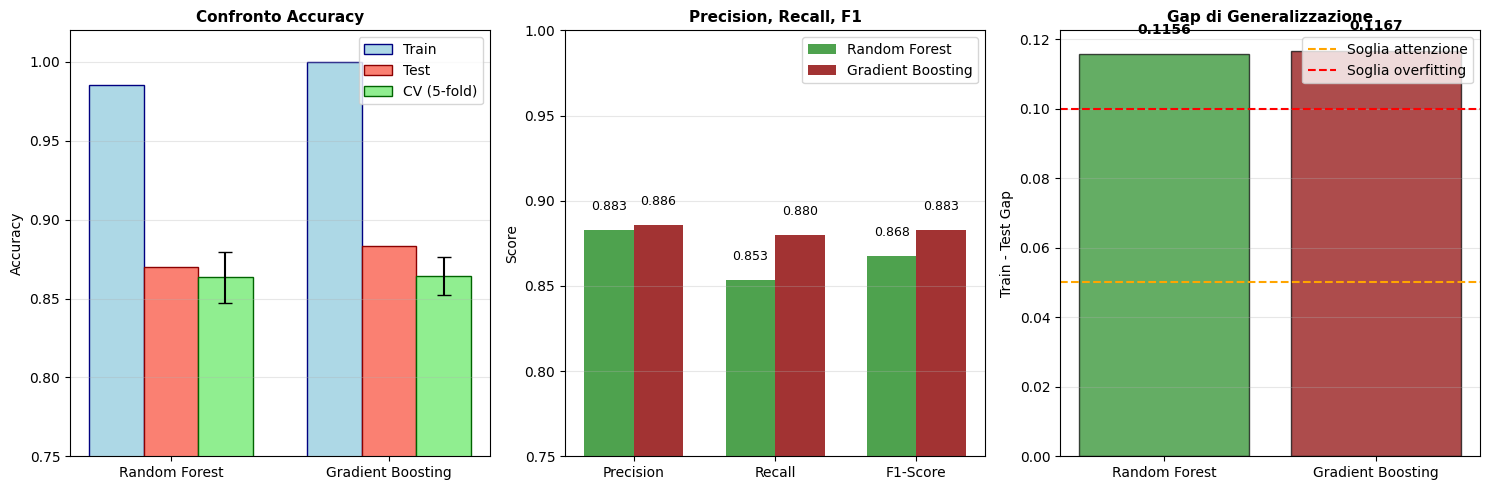


🏆 CONCLUSIONI DEL CONFRONTO:
------------------------------------------------------------
• Migliore Test Accuracy: Gradient Boosting (0.8833)
• Migliore CV Accuracy:   Gradient Boosting (0.8642)
• Gap più basso:          Random Forest


In [8]:
# Visualizzazione del confronto

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

model_names = list(results_comparison.keys())
colors = ['forestgreen', 'darkred']

# Plot 1: Accuracy (Train, Test, CV)
ax1 = axes[0]
x = np.arange(len(model_names))
width = 0.25

train_accs = [results_comparison[m]['train_acc'] for m in model_names]
test_accs = [results_comparison[m]['test_acc'] for m in model_names]
cv_means = [results_comparison[m]['cv_mean'] for m in model_names]
cv_stds = [results_comparison[m]['cv_std'] for m in model_names]

bars1 = ax1.bar(x - width, train_accs, width, label='Train', color='lightblue', edgecolor='navy')
bars2 = ax1.bar(x, test_accs, width, label='Test', color='salmon', edgecolor='darkred')
bars3 = ax1.bar(x + width, cv_means, width, yerr=cv_stds, label='CV (5-fold)', 
                color='lightgreen', edgecolor='darkgreen', capsize=5)

ax1.set_ylabel('Accuracy')
ax1.set_title('Confronto Accuracy', fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.set_ylim([0.75, 1.02])
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Precision, Recall, F1
ax2 = axes[1]
metrics = ['precision', 'recall', 'f1']
x2 = np.arange(len(metrics))
width2 = 0.35

rf_metrics = [results_comparison['Random Forest'][m] for m in metrics]
gb_metrics = [results_comparison['Gradient Boosting'][m] for m in metrics]

bars_rf = ax2.bar(x2 - width2/2, rf_metrics, width2, label='Random Forest', color='forestgreen', alpha=0.8)
bars_gb = ax2.bar(x2 + width2/2, gb_metrics, width2, label='Gradient Boosting', color='darkred', alpha=0.8)

ax2.set_ylabel('Score')
ax2.set_title('Precision, Recall, F1', fontsize=11, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
ax2.legend()
ax2.set_ylim([0.75, 1.0])
ax2.grid(True, alpha=0.3, axis='y')

# Valori sopra le barre
for bar, val in zip(bars_rf, rf_metrics):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars_gb, gb_metrics):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9)

# Plot 3: Gap (indicatore overfitting)
ax3 = axes[2]
gaps = [results_comparison[m]['gap'] for m in model_names]
colors_gap = ['forestgreen', 'darkred']
bars = ax3.bar(model_names, gaps, color=colors_gap, alpha=0.7, edgecolor='black')
ax3.axhline(y=0.05, color='orange', linestyle='--', label='Soglia attenzione')
ax3.axhline(y=0.1, color='red', linestyle='--', label='Soglia overfitting')
ax3.set_ylabel('Train - Test Gap')
ax3.set_title('Gap di Generalizzazione', fontsize=11, fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3, axis='y')

for bar, g in zip(bars, gaps):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{g:.4f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🏆 CONCLUSIONI DEL CONFRONTO:")
print("-" * 60)
winner_acc = max(results_comparison.items(), key=lambda x: x[1]['test_acc'])
winner_cv = max(results_comparison.items(), key=lambda x: x[1]['cv_mean'])
print(f"• Migliore Test Accuracy: {winner_acc[0]} ({winner_acc[1]['test_acc']:.4f})")
print(f"• Migliore CV Accuracy:   {winner_cv[0]} ({winner_cv[1]['cv_mean']:.4f})")
print(f"• Gap più basso:          {min(results_comparison.items(), key=lambda x: x[1]['gap'])[0]}")

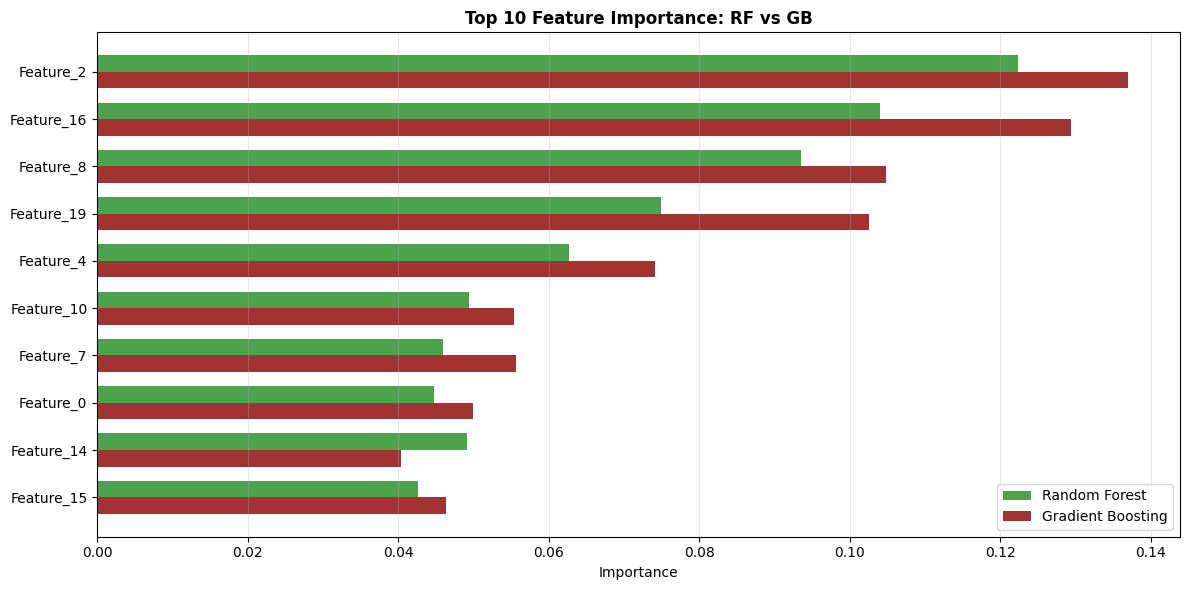


📊 OSSERVAZIONI SULLA FEATURE IMPORTANCE:
------------------------------------------------------------
• RF e GB possono assegnare importanze diverse alle stesse feature
• GB tende a concentrare l'importanza su meno feature
• RF distribuisce l'importanza più uniformemente
• Entrambi identificano le feature informative principali


In [9]:
# Feature Importance: confronto tra RF e GB

# Estrai feature importance
rf_model = models['Random Forest']
gb_model = models['Gradient Boosting']

rf_importance = rf_model.feature_importances_
gb_importance = gb_model.feature_importances_

# Ordina per importanza media
avg_importance = (rf_importance + gb_importance) / 2
sorted_idx = np.argsort(avg_importance)[::-1][:10]  # Top 10

feature_names_demo = [f'Feature_{i}' for i in range(X_full.shape[1])]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(sorted_idx))
width = 0.35

bars1 = ax.barh(x - width/2, rf_importance[sorted_idx], width, 
                label='Random Forest', color='forestgreen', alpha=0.8)
bars2 = ax.barh(x + width/2, gb_importance[sorted_idx], width, 
                label='Gradient Boosting', color='darkred', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels([feature_names_demo[i] for i in sorted_idx])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importance: RF vs GB', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 OSSERVAZIONI SULLA FEATURE IMPORTANCE:")
print("-" * 60)
print("• RF e GB possono assegnare importanze diverse alle stesse feature")
print("• GB tende a concentrare l'importanza su meno feature")
print("• RF distribuisce l'importanza più uniformemente")
print("• Entrambi identificano le feature informative principali")

# Section 7 — Esercizi Svolti

In questa sezione applichiamo i concetti appresi attraverso esercizi pratici completamente risolti.
Ogni passaggio è commentato per facilitare la comprensione.

---

## Esercizio 10.1 — Tuning Manuale del Learning Rate

**Obiettivo**: Trovare il learning rate ottimale per un Gradient Boosting.

**Cosa faremo**:
1. Testeremo diversi valori di `learning_rate` (0.01, 0.05, 0.1, 0.2, 0.3)
2. Manterremo `n_estimators=100` e `max_depth=3` fissi
3. Useremo cross-validation per valutare ogni configurazione
4. Identificheremo il learning rate che massimizza la CV accuracy

In [11]:
# ESERCIZIO 10.1 — Tuning del Learning Rate (SVOLTO)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Creiamo un dataset per l'esercizio
# - 800 campioni, 12 feature, 6 informative
# - flip_y=0.12 introduce rumore nelle etichette
X_ex, y_ex = make_classification(
    n_samples=800, n_features=12, n_informative=6, 
    flip_y=0.12, random_state=42
)

# Definiamo i learning rate da testare
# - Partiamo da valori molto bassi (0.01) a valori più alti (0.3)
learning_rates_test = [0.01, 0.05, 0.1, 0.2, 0.3]

# Dizionario per salvare i risultati
# - Chiave: learning_rate
# - Valore: dizionario con media e std della CV accuracy
results = {}

print("="*60)
print("TUNING DEL LEARNING RATE - Gradient Boosting")
print("="*60)
print(f"Parametri fissi: n_estimators=100, max_depth=3")
print(f"Validazione: 5-fold cross-validation")
print("-"*60)

# Loop su ogni learning rate
for lr in learning_rates_test:
    # Creiamo il modello con il learning rate corrente
    # - n_estimators=100: numero di alberi fisso
    # - max_depth=3: alberi poco profondi (tipico per boosting)
    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    
    # Cross-validation a 5 fold
    # - Calcola l'accuracy su 5 split diversi
    # - Restituisce un array con 5 valori
    cv_scores = cross_val_score(gb, X_ex, y_ex, cv=5, scoring='accuracy')
    
    # Salviamo media e deviazione standard
    results[lr] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    
    # Stampa il risultato per questo learning rate
    print(f"lr={lr:.2f}: CV Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("-"*60)

# Troviamo il learning rate migliore
# - Usiamo max() con una funzione chiave che estrae la media
best_lr = max(results.keys(), key=lambda x: results[x]['mean'])
best_score = results[best_lr]['mean']

print(f"\n🏆 Migliore learning_rate: {best_lr}")
print(f"   CV Accuracy: {best_score:.4f}")

# INTERPRETAZIONE DEI RISULTATI
print("\n" + "="*60)
print("INTERPRETAZIONE")
print("="*60)
print("""
Osservazioni:
• Learning rate troppo basso (0.01): convergenza lenta, potrebbe
  non raggiungere il massimo con solo 100 alberi
  
• Learning rate troppo alto (0.3): rischio di overfitting, 
  correzioni troppo aggressive

• Il valore ottimale è tipicamente tra 0.05 e 0.2

• Regola pratica: se abbassi il learning_rate, aumenta n_estimators
  (e viceversa) per mantenere la stessa capacità espressiva
""")

TUNING DEL LEARNING RATE - Gradient Boosting
Parametri fissi: n_estimators=100, max_depth=3
Validazione: 5-fold cross-validation
------------------------------------------------------------
lr=0.01: CV Accuracy = 0.8300 ± 0.0315
lr=0.05: CV Accuracy = 0.8475 ± 0.0264
lr=0.10: CV Accuracy = 0.8438 ± 0.0401
lr=0.20: CV Accuracy = 0.8425 ± 0.0329
lr=0.30: CV Accuracy = 0.8250 ± 0.0413
------------------------------------------------------------

🏆 Migliore learning_rate: 0.05
   CV Accuracy: 0.8475

INTERPRETAZIONE

Osservazioni:
• Learning rate troppo basso (0.01): convergenza lenta, potrebbe
  non raggiungere il massimo con solo 100 alberi

• Learning rate troppo alto (0.3): rischio di overfitting, 
  correzioni troppo aggressive

• Il valore ottimale è tipicamente tra 0.05 e 0.2

• Regola pratica: se abbassi il learning_rate, aumenta n_estimators
  (e viceversa) per mantenere la stessa capacità espressiva



---

## Esercizio 10.2 — Interpretazione dei Risultati

**Obiettivo**: Analizzare e interpretare le metriche di un modello addestrato.

**Cosa faremo**:
1. Addestreremo un Gradient Boosting sul dataset dell'esercizio precedente
2. Calcoleremo tutte le metriche: accuracy, precision, recall, F1
3. Genereremo un classification report
4. Interpreteremo i risultati in modo critico

In [12]:
# ESERCIZIO 10.2 — Interpretazione dei Risultati (SVOLTO)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Split dei dati in train e test
# - test_size=0.25: 25% per il test
# - stratify=y_ex: mantiene la proporzione delle classi
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(
    X_ex, y_ex, test_size=0.25, stratify=y_ex, random_state=42
)

print("="*60)
print("INTERPRETAZIONE DELLE METRICHE - Gradient Boosting")
print("="*60)
print(f"Training set: {len(X_train_ex)} campioni")
print(f"Test set: {len(X_test_ex)} campioni")
print("-"*60)

# Addestriamo il modello con il learning rate ottimale trovato prima
# Usiamo lr=0.1 come valore ragionevole
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Addestramento sul training set
gb_model.fit(X_train_ex, y_train_ex)

# Predizioni sul test set
y_pred = gb_model.predict(X_test_ex)

# Calcoliamo tutte le metriche
accuracy = accuracy_score(y_test_ex, y_pred)
precision = precision_score(y_test_ex, y_pred)
recall = recall_score(y_test_ex, y_pred)
f1 = f1_score(y_test_ex, y_pred)

print("\n📊 METRICHE DEL MODELLO")
print("-"*60)
print(f"Accuracy:  {accuracy:.4f}  (% predizioni corrette sul totale)")
print(f"Precision: {precision:.4f}  (tra i predetti positivi, quanti sono veri)")
print(f"Recall:    {recall:.4f}  (tra i veri positivi, quanti abbiamo trovato)")
print(f"F1-Score:  {f1:.4f}  (media armonica di precision e recall)")

# Classification report completo
print("\n📋 CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(y_test_ex, y_pred, target_names=['Classe 0', 'Classe 1']))

# INTERPRETAZIONE
print("="*60)
print("INTERPRETAZIONE DEI RISULTATI")
print("="*60)

# Confrontiamo precision e recall
if precision > recall:
    print("• Il modello è più PRECISO: evita i falsi positivi")
    print("  → Utile quando i falsi positivi hanno un costo alto")
elif recall > precision:
    print("• Il modello ha maggior RECALL: trova più positivi")
    print("  → Utile quando non vogliamo perdere casi positivi")
else:
    print("• Precision e Recall sono bilanciati")

# Confronto tra classi
print("\n• Analisi per classe:")
print("  - Guarda il support (numero di campioni per classe)")
print("  - La classe con F1 più basso è più difficile da classificare")
print("  - Un modello bilanciato ha metriche simili per entrambe le classi")

INTERPRETAZIONE DELLE METRICHE - Gradient Boosting
Training set: 600 campioni
Test set: 200 campioni
------------------------------------------------------------

📊 METRICHE DEL MODELLO
------------------------------------------------------------
Accuracy:  0.8250  (% predizioni corrette sul totale)
Precision: 0.8384  (tra i predetti positivi, quanti sono veri)
Recall:    0.8137  (tra i veri positivi, quanti abbiamo trovato)
F1-Score:  0.8259  (media armonica di precision e recall)

📋 CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

    Classe 0       0.81      0.84      0.82        98
    Classe 1       0.84      0.81      0.83       102

    accuracy                           0.82       200
   macro avg       0.83      0.83      0.82       200
weighted avg       0.83      0.82      0.83       200

INTERPRETAZIONE DEI RISULTATI
• Il modello è più PRECISO: evita i falsi positivi
  → Utile quando i 

---

## Esercizio 10.3 — Confronto Finale RF vs GB

**Obiettivo**: Eseguire un confronto sistematico tra Random Forest e Gradient Boosting.

**Cosa faremo**:
1. Creeremo un dataset con rumore elevato (flip_y=0.15)
2. Addestreremo entrambi i modelli con parametri comparabili
3. Confronteremo usando cross-validation a 5 fold
4. Visualizzeremo i risultati e trarremo conclusioni pratiche

CONFRONTO FINALE: Random Forest vs Gradient Boosting
Dataset: 600 campioni, 15 features
Rumore: 15% delle etichette sono errate
------------------------------------------------------------

Esecuzione cross-validation (5 fold)...

📊 RISULTATI CROSS-VALIDATION
------------------------------------------------------------
Random Forest:     0.8100 ± 0.0143
Gradient Boosting: 0.8133 ± 0.0135

🏆 VERDETTO
------------------------------------------------------------
Gradient Boosting vince con +0.0033 di accuracy
→ La differenza è minima, entrambi sono validi

📏 ANALISI DELLA STABILITÀ
------------------------------------------------------------
Random Forest std:     0.0143
Gradient Boosting std: 0.0135
→ Gradient Boosting è più stabile (meno varianza tra i fold)


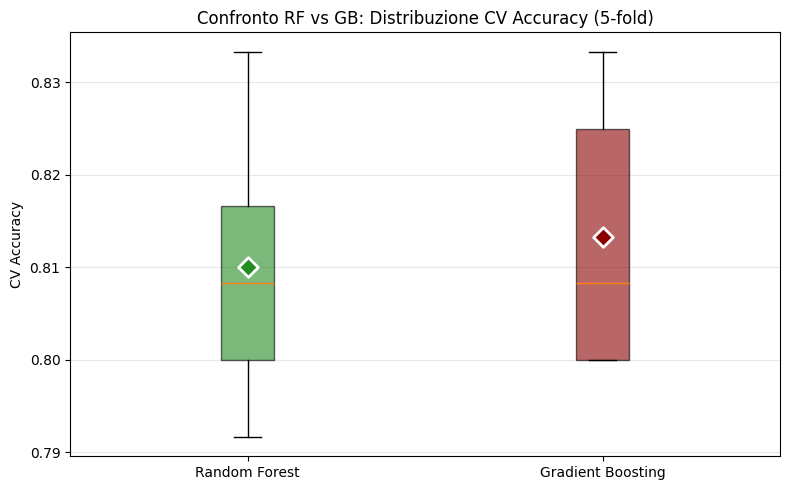


CONCLUSIONI

Osservazioni dal confronto:

1. PERFORMANCE: Su dataset rumorosi, la differenza è spesso piccola

2. STABILITÀ: RF tende ad essere più stabile (std più bassa)
   → Preferibile quando serve prevedibilità

3. QUANDO SCEGLIERE RF:
   - Dati molto rumorosi
   - Poco tempo per tuning
   - Serve parallelizzazione

4. QUANDO SCEGLIERE GB:
   - Si vuole massimizzare la performance
   - Si ha tempo per ottimizzare gli iperparametri
   - Dataset grandi e puliti



In [13]:
# ESERCIZIO 10.3 — Confronto Finale RF vs GB (SVOLTO)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Creiamo un nuovo dataset con rumore più alto
# - flip_y=0.15: 15% di etichette errate (dataset impegnativo)
X_final, y_final = make_classification(
    n_samples=600, 
    n_features=15, 
    n_informative=8,
    n_redundant=3,
    flip_y=0.15, 
    random_state=42
)

print("="*60)
print("CONFRONTO FINALE: Random Forest vs Gradient Boosting")
print("="*60)
print(f"Dataset: {X_final.shape[0]} campioni, {X_final.shape[1]} features")
print(f"Rumore: 15% delle etichette sono errate")
print("-"*60)

# Definiamo i due modelli con parametri comparabili
rf_final = RandomForestClassifier(
    n_estimators=100,     # 100 alberi
    max_depth=8,          # profondità massima
    min_samples_split=5,  # campioni minimi per split
    random_state=42
)

gb_final = GradientBoostingClassifier(
    n_estimators=100,     # 100 alberi
    learning_rate=0.1,    # learning rate medio
    max_depth=4,          # alberi più bassi (tipico per boosting)
    subsample=0.8,        # 80% dei campioni per albero
    random_state=42
)

# Cross-validation a 5 fold per entrambi
print("\nEsecuzione cross-validation (5 fold)...")
cv_rf = cross_val_score(rf_final, X_final, y_final, cv=5, scoring='accuracy')
cv_gb = cross_val_score(gb_final, X_final, y_final, cv=5, scoring='accuracy')

# Stampa risultati
print("\n📊 RISULTATI CROSS-VALIDATION")
print("-"*60)
print(f"Random Forest:     {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")
print(f"Gradient Boosting: {cv_gb.mean():.4f} ± {cv_gb.std():.4f}")

# Determiniamo il vincitore
print("\n🏆 VERDETTO")
print("-"*60)
if cv_gb.mean() > cv_rf.mean():
    diff = cv_gb.mean() - cv_rf.mean()
    print(f"Gradient Boosting vince con +{diff:.4f} di accuracy")
    if diff < 0.01:
        print("→ La differenza è minima, entrambi sono validi")
elif cv_rf.mean() > cv_gb.mean():
    diff = cv_rf.mean() - cv_gb.mean()
    print(f"Random Forest vince con +{diff:.4f} di accuracy")
    if diff < 0.01:
        print("→ La differenza è minima, entrambi sono validi")
else:
    print("Pareggio! Entrambi i modelli hanno la stessa performance")

# Confronto della stabilità
print("\n📏 ANALISI DELLA STABILITÀ")
print("-"*60)
print(f"Random Forest std:     {cv_rf.std():.4f}")
print(f"Gradient Boosting std: {cv_gb.std():.4f}")
if cv_rf.std() < cv_gb.std():
    print("→ Random Forest è più stabile (meno varianza tra i fold)")
else:
    print("→ Gradient Boosting è più stabile (meno varianza tra i fold)")

# Visualizzazione con boxplot
fig, ax = plt.subplots(figsize=(8, 5))

# Creiamo il boxplot
box_data = [cv_rf, cv_gb]
bp = ax.boxplot(box_data, labels=['Random Forest', 'Gradient Boosting'], 
                patch_artist=True)

# Colori
colors = ['forestgreen', 'darkred']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('CV Accuracy')
ax.set_title('Confronto RF vs GB: Distribuzione CV Accuracy (5-fold)')
ax.grid(True, alpha=0.3, axis='y')

# Aggiungi i valori medi
for i, (data, color) in enumerate(zip(box_data, colors)):
    ax.scatter([i+1], [data.mean()], color=color, s=100, zorder=5, 
               marker='D', edgecolor='white', linewidth=2)

plt.tight_layout()
plt.show()

# CONCLUSIONI
print("\n" + "="*60)
print("CONCLUSIONI")
print("="*60)
print("""
Osservazioni dal confronto:

1. PERFORMANCE: Su dataset rumorosi, la differenza è spesso piccola
   
2. STABILITÀ: RF tende ad essere più stabile (std più bassa)
   → Preferibile quando serve prevedibilità
   
3. QUANDO SCEGLIERE RF:
   - Dati molto rumorosi
   - Poco tempo per tuning
   - Serve parallelizzazione
   
4. QUANDO SCEGLIERE GB:
   - Si vuole massimizzare la performance
   - Si ha tempo per ottimizzare gli iperparametri
   - Dataset grandi e puliti
""")

# Section 8 — Conclusioni e Prossimi Passi

## 8.1 — Cosa Abbiamo Imparato

In questa lezione abbiamo esplorato il **Gradient Boosting**, un algoritmo potente che costruisce modelli sequenzialmente, correggendo gli errori dei modelli precedenti.

### Concetti Chiave

| Concetto | Cosa ricordare |
|----------|----------------|
| **Boosting** | Costruzione sequenziale, ogni modello corregge gli errori |
| **RF vs GB** | RF riduce varianza (parallelo), GB riduce bias (sequenziale) |
| **Overfitting** | GB più soggetto, richiede tuning attento |
| **Learning Rate** | Più basso = più stabile ma più lento |
| **n_estimators** | Più alto = potenzialmente meglio, ma rischio overfit |
| **max_depth** | Per GB preferire alberi poco profondi (3-5) |

## 8.2 — Quando Usare Cosa

```
Dataset con RUMORE ALTO?
    → Random Forest (più robusto)

Serve MASSIMA PERFORMANCE?
    → Gradient Boosting (con tuning)

POCO TEMPO per tuning?
    → Random Forest (funziona bene out-of-the-box)

Dataset MOLTO GRANDE?
    → Random Forest (parallelizzabile)
    → oppure XGBoost/LightGBM (ottimizzati)
```

## 8.3 — Il Problema che Rimane: Hyperparameter Tuning

Abbiamo visto che il Gradient Boosting richiede una **selezione attenta degli iperparametri**:
- `learning_rate`
- `n_estimators`
- `max_depth`
- `subsample`
- ... e molti altri!

**Problema**: Come trovare la combinazione ottimale in modo sistematico?

## 8.4 — Perché Servono Pipeline e Validazione Avanzata

Nella prossima lezione affronteremo:

1. **Grid Search e Random Search**: ricerca automatica degli iperparametri
2. **Pipeline**: concatenare preprocessing + modello in un unico oggetto
3. **Cross-Validation Stratificata**: validazione robusta per dataset sbilanciati
4. **Evitare il Data Leakage**: errori comuni che invalidano i risultati

### Preview della Lezione 11

```python
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline: preprocessing + modello
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier())
])

# Grid Search: trova i parametri ottimali automaticamente
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 5]
}

search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
search.fit(X_train, y_train)

print(f"Best params: {search.best_params_}")
print(f"Best score: {search.best_score_}")
```

---

## 8.5 — Riepilogo del Percorso

| Lezione | Argomento | Focus |
|---------|-----------|-------|
| 7 | Logistic Regression | Classificazione base |
| 8 | Validazione e Overfitting | Train/Test/CV |
| 9 | Decision Tree & Random Forest | Ensemble (Bagging) |
| **10** | **Gradient Boosting** | **Ensemble (Boosting)** |
| 11 | Pipeline e Grid Search | Tuning automatico |

---

**🎯 Take-away finale**: Il Gradient Boosting è uno strumento potente, ma richiede comprensione profonda per essere usato correttamente. La prossima lezione ti darà gli strumenti per ottimizzarlo in modo sistematico.

---

# Appendice — Bignami della Lezione 10

## 🚀 Gradient Boosting in 30 secondi
```
F₀(x) = media(y)
Per m = 1, ..., M:
    residui = y - Fₘ₋₁(x)
    addestra hₘ sui residui
    Fₘ(x) = Fₘ₋₁(x) + η · hₘ(x)
```

## 📐 Formula Chiave

$$F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot h_m(x)$$

## 🔄 RF vs GB

| | Random Forest | Gradient Boosting |
|-|---------------|-------------------|
| Tipo | Parallelo | Sequenziale |
| Riduce | Varianza | Bias |
| Alberi | Profondi | Poco profondi |
| Overfit | Robusto | Sensibile |

## ⚙️ Parametri Chiave

| Parametro | Default | Suggerimento |
|-----------|---------|--------------|
| `n_estimators` | 100 | 100-300 |
| `learning_rate` | 0.1 | 0.01-0.2 |
| `max_depth` | 3 | 3-5 per GB |
| `subsample` | 1.0 | 0.7-0.9 anti-overfit |

## 🎯 Regola d'Oro
```
learning_rate ↓ + n_estimators ↑ = Più stabile
learning_rate × n_estimators ≈ 10-30
```

## 🐍 Scikit-learn Cheatsheet

```python
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)
gb.predict(X_test)
gb.feature_importances_
```

## ⚠️ Errori Comuni
1. ❌ `learning_rate` troppo alto → overfitting rapido
2. ❌ Troppi `n_estimators` senza early stopping → overfit
3. ❌ `max_depth` alto → alberi troppo complessi
4. ❌ Non fare cross-validation → stima inaffidabile
5. ❌ Ignorare il gap train-test → non rilevare overfitting